# Assess Quality of E<sub>min</sub> Measured Different Ways

There are two key approximations one can make when computing E<sub>min</sub>:

1. The quality of the quantum chemistry
1. The breadth of molecules one evaluates

We explore the effect of both here.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from emin.source import get_inchi_keys_from_pubchem
from pathlib import Path
import pandas as pd
import numpy as np

## Load Data
Load the initial QM9 data and then the energies at different approximation levels

In [2]:
qm9 = pd.read_json('data/qm9.json.gz', lines=True)
print(f'Loaded {len(qm9)} molecules')

Loaded 126405 molecules


Load each file and then join to the main table

In [3]:
energy_paths = list(Path('data/qm9-energies/').glob('*.csv'))
energy_levels = []
for path in energy_paths:
    level_name = path.name[:-4]
    energy_levels.append(level_name)
    new_subset = pd.read_csv(path, names=('inchi_key', f'runtime_{level_name}', f'energy_{level_name}'))
    qm9 = qm9.merge(new_subset, how='inner', on='inchi_key', suffixes=('', ''))
energy_level = [p.name[:-4] for p in energy_paths]
print(f'Loaded data from {len(energy_paths)} levels of accuracy: {", ".join(energy_level)}')

Loaded data from 4 levels of accuracy: xtb-True, xtb-False, mmff94-False, mmff94-True


In [4]:
qm9.columns

Index(['A', 'B', 'C', 'R2', 'alpha', 'atomic_charges', 'bandgap', 'cv',
       'filename', 'g', 'g4mp2_0k', 'g4mp2_atom', 'g4mp2_energy',
       'g4mp2_enthalpy', 'g4mp2_free', 'g4mp2_hf298', 'g4mp2_zpe', 'h', 'homo',
       'inchi_0', 'inchi_1', 'index', 'lumo', 'mu', 'n_atom', 'n_electrons',
       'n_heavy_atoms', 'smiles_0', 'smiles_1', 'u', 'u0', 'u0_atom', 'xyz',
       'zpe', 'in_holdout', 'formula', 'inchi_key', 'in_pubchem',
       'runtime_xtb-True', 'energy_xtb-True', 'runtime_xtb-False',
       'energy_xtb-False', 'runtime_mmff94-False', 'energy_mmff94-False',
       'runtime_mmff94-True', 'energy_mmff94-True'],
      dtype='object')

## Compute E_min with different energy approximations
Evaluate all of the molecules, just do so with a cheaper method. We explore changing the method and whether we optimize the coordinates

In [5]:
for level in energy_level:
    qm9[f'{level}_emin'] = qm9[f'energy_{level}'] - qm9.groupby('formula')[f'energy_{level}'].transform('min')

In [6]:
for level in ['g4mp2_energy', 'u0']:
    qm9[f'{level}_emin'] = qm9[level] - qm9.groupby('formula')[level].transform('min')

Set the colors for the original (old) energies and the new ones we compute

In [7]:
old_colors = {'g4mp2_energy': ('goldenrod', 'G4MP2'), 'u0': ('crimson', 'B3LYP')}
new_colors = {'mmff94': 'deepskyblue', 'xtb': 'seagreen'}

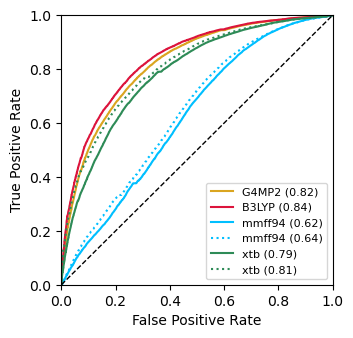

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

for old, (color, label) in old_colors.items():
    fpr, tpr, thr = roc_curve(np.logical_not(qm9['in_pubchem']), qm9[f'{old}_emin'])
    auc = roc_auc_score(np.logical_not(qm9['in_pubchem']), qm9[f'{old}_emin'])
    ax.plot(fpr, tpr, color=color, label=f'{label} ({auc:.2f})')
    
for level, color in new_colors.items():
    for relax in [True, False]:
        tag = f'{level}-{relax}_emin'
        mask = np.logical_not(qm9[tag].isnull())
        fpr, tpr, thr = roc_curve(np.logical_not(qm9[mask]['in_pubchem']), qm9[mask][tag])
        auc = roc_auc_score(np.logical_not(qm9[mask]['in_pubchem']), qm9[mask][tag])
        ax.plot(fpr, tpr, '-' if relax else ':', color=color, label=f'{level} ({auc:.2f})')

        ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.plot([0, 1], [0, 1], 'k--', lw=1)

ax.legend(fontsize=8)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

fig.savefig('figures/emin_roc-by-level.png', dpi=320)

The results do generally get better with better quantum chemistry. B3LYP and G4MP2 are above 80%, with xTB close behind.

## Sampling Quality
We could get away with computing E_min using fewer molecules if we assume the lowest-energy one is in PubChem.

In [9]:
for level in energy_level:
    per_group = qm9.query('in_pubchem').groupby('formula')[f'energy_{level}'].min()
    qm9[f'{level}_emin-pconly'] = qm9[f'energy_{level}'] - qm9['formula'].map(per_group)

In [10]:
for level in ['g4mp2_energy', 'u0']:
    per_group = qm9.query('in_pubchem').groupby('formula')[level].min()
    qm9[f'{level}_emin-pconly'] = qm9[level] - qm9.groupby('formula')[level].transform('min')

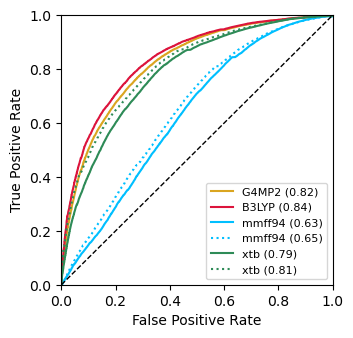

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

for old, (color, label) in old_colors.items():
    fpr, tpr, thr = roc_curve(np.logical_not(qm9['in_pubchem']), qm9[f'{old}_emin-pconly'])
    auc = roc_auc_score(np.logical_not(qm9['in_pubchem']), qm9[f'{old}_emin-pconly'])
    ax.plot(fpr, tpr, color=color, label=f'{label} ({auc:.2f})')
    
for level, color in new_colors.items():
    for relax in [True, False]:
        tag = f'{level}-{relax}_emin-pconly'
        mask = np.logical_not(qm9[tag].isnull())
        fpr, tpr, thr = roc_curve(np.logical_not(qm9[mask]['in_pubchem']), qm9[mask][tag])
        auc = roc_auc_score(np.logical_not(qm9[mask]['in_pubchem']), qm9[mask][tag])
        ax.plot(fpr, tpr, '-' if relax else ':', color=color, label=f'{level} ({auc:.2f})')

        ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.plot([0, 1], [0, 1], 'k--', lw=1)

ax.legend(fontsize=8)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

fig.savefig('figures/emin_roc-by-level.png', dpi=320)

There are no significant differences in performance with only assessing energy against molecules in PubChem.

## Conclusion
Given all these, we think that running xTB without relaxation on only PubChem is a good way to assess energies.

In [12]:
summary = []
for level, color in new_colors.items():
    for relax in [True, False]:
        tag = f'{level}-{relax}'
        runtime = qm9.query('in_pubchem').groupby('formula')[f'runtime_{tag}'].sum().mean()
        mask = np.logical_not(qm9[f'{tag}_emin-pconly'].isnull())
        auc = roc_auc_score(np.logical_not(qm9[mask]['in_pubchem']), qm9[mask][f'{tag}_emin-pconly'])
        summary.append({
            'level': level,
            'relax': relax,
            'runtime': runtime,
            'auc': auc,
        })
summary = pd.DataFrame(summary)
summary

,level,relax,runtime,auc
0,mmff94,True,1.932198,0.629857
1,mmff94,False,1.074024,0.650188
2,xtb,True,640.344332,0.787051
3,xtb,False,11.710020,0.809429


We are ~11s per compound with the xTB without relaxation, which is only 10x more than mmff94 (the fastest possible). All measured on a KNL process with 4 tasks per processor.